Aleksandra Bednarczuk

# Predictors of elderly citizens willingness to stay in the neighbourhood
# Logistic regression

Original dataset

In [49]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [50]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import r2_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from scipy import stats

In [51]:
data = pd.read_pickle("survey_transformed.pkl")

In [52]:
data.head()

,ANY,Would_live_in_another_neighborhood,District,Gender,Place_of_birth,Time_living_in_barri,Barri_evolution,BCN_evolution,Barri_future,BCN_future,...,House_size,Monthly_family_income,Social_class,Living_alone,BCN_over_barri_evolution,BCN_over_barri_future,BCN_over_barri_satisfaction_of_living,BCN_over_barri_transport,BCN_over_barri_management,BCN_over_barri_citizen_security
0,2008,0.0,CIUTAT VELLA,1,BARCELONA,I HAVE ALWAYS LIVED IN THE NEIGHBORHOOD,IT IS THE SAME,IT IS WORSE,IT WILL STAY THE SAME,IT WILL GET WORSE,...,< 50 M2,< 1000 EUROS,MIDDLE-MIDDLE,ONE,0,0,0,0,0,0
1,2008,0.0,CIUTAT VELLA,1,REST OF SPAIN,MORE THAN 10 YEARS,IT IS THE SAME,IT HAS IMPROVED,IT WILL IMPROVE,IT WILL IMPROVE,...,51-100 M2,< 1000 EUROS,LOW,TWO,1,0,0,0,0,0
3,2008,0.0,CIUTAT VELLA,0,REST OF CATALONIA,MORE THAN 10 YEARS,IT HAS IMPROVED,IT IS WORSE,IT WILL IMPROVE,IT WILL GET WORSE,...,51-100 M2,1001-2000 EUROS,MIDDLE-LOW,THREE,0,0,0,0,0,0
5,2008,0.0,CIUTAT VELLA,0,BARCELONA,I HAVE ALWAYS LIVED IN THE NEIGHBORHOOD,IT IS THE SAME,IT IS WORSE,IT WILL IMPROVE,IT WILL STAY THE SAME,...,51-100 M2,< 1000 EUROS,MIDDLE-LOW,THREE,0,0,0,0,0,0
6,2008,0.0,CIUTAT VELLA,1,BARCELONA,I HAVE ALWAYS LIVED IN THE NEIGHBORHOOD,IT IS WORSE,IT IS WORSE,IT WILL GET WORSE,IT WILL GET WORSE,...,51-100 M2,< 1000 EUROS,LOW,ONE,0,0,1,0,0,0


In [53]:
data.shape

(15091, 40)

In [54]:
# Dataset is imbalanced
data.groupby(['Would_live_in_another_neighborhood']).size()

Would_live_in_another_neighborhood
0.0    13454
1.0     1637
dtype: int64

In [55]:
data.columns.tolist()

['ANY',
 'Would_live_in_another_neighborhood',
 'District',
 'Gender',
 'Place_of_birth',
 'Time_living_in_barri',
 'Barri_evolution',
 'BCN_evolution',
 'Barri_future',
 'BCN_future',
 'Barri_satisfaction_of_living',
 'BCN_satisfaction_of_living',
 'Barri_citizen_security',
 'BCN_citizen_security',
 'Barri_management',
 'BCN_management',
 'Barri_comparison',
 'STREETS CLEANING',
 'NOISE',
 'GREEN AREAS',
 'PUBLIC LIGHTING',
 'URBANISM',
 'ASPHALT AND STREET CONSERVATION',
 'CIRCULATION',
 'BUS',
 'SUBWAY',
 'MUNICIPAL MARKETS',
 'Barri_transport',
 'BCN_transport',
 'Owns_a_car',
 'House_size',
 'Monthly_family_income',
 'Social_class',
 'Living_alone',
 'BCN_over_barri_evolution',
 'BCN_over_barri_future',
 'BCN_over_barri_satisfaction_of_living',
 'BCN_over_barri_transport',
 'BCN_over_barri_management',
 'BCN_over_barri_citizen_security']

In [56]:
x_var = ['ANY',
 'Would_live_in_another_neighborhood',
 'District',
 'Gender',
 'Place_of_birth',
 'Time_living_in_barri',
 'Barri_evolution',
 'BCN_evolution',
 'Barri_future',
 'BCN_future',
 'Barri_satisfaction_of_living',
 'BCN_satisfaction_of_living',
 'Barri_citizen_security',
 'BCN_citizen_security',
 'Barri_management',
 'BCN_management',
 'Barri_comparison',
 'Barri_transport',
 'BCN_transport',
 'Owns_a_car',
 'House_size',
 'Monthly_family_income',
 'Social_class',
 'Living_alone',
 'BCN_over_barri_evolution',
 'BCN_over_barri_future',
 'BCN_over_barri_satisfaction_of_living',
 'BCN_over_barri_transport',
 'BCN_over_barri_management',
 'BCN_over_barri_citizen_security']

In [57]:
for i in ['ANY', 
          'Would_live_in_another_neighborhood', 
          'BCN_evolution', 'BCN_future', 'BCN_satisfaction_of_living', 
          'BCN_transport', 'BCN_management', 'BCN_citizen_security']:
    x_var.remove(i)

In [58]:
x = data[x_var]

In [59]:
y = data['Would_live_in_another_neighborhood']

In [60]:
x = pd.get_dummies(x, drop_first=True)

In [61]:
# for i in x.columns.tolist():
#     if i[-5:] == '_GOOD':
#         del x[i]        

In [62]:
# for i in ['Place_of_birth_BARCELONA',
 
#  'Time_living_in_barri_I HAVE ALWAYS LIVED IN THE NEIGHBORHOOD',

#  'Barri_evolution_IT IS WORSE',
 
#  'Barri_future_IT WILL GET WORSE',
 
#  'Barri_satisfaction_of_living_NOT SATISFIED',

#  'Barri_comparison_ONE OF THE WORST',

#  'House_size_< 50 M2',

#  'Monthly_family_income_< 1000 EUROS',

#  'Social_class_LOW',

#  'Living_alone_ONE']:
#     del x[i]

In [63]:
x = sm.add_constant(x)

In [64]:
resampling = SMOTETomek(random_state=0)
 
columns = x.columns
x_resampled, y_resampled = resampling.fit_sample(x.astype(int), y)
x_resampled = pd.DataFrame(data=x_resampled, columns=columns )
y_resampled= pd.DataFrame(data=y_resampled, columns=['Would_live_in_another_neighborhood'])

print("length of oversampled data is ",len(x_resampled))
print("Number of people who would not stay in the neighborhood in resampled data",
      len(y_resampled[y_resampled['Would_live_in_another_neighborhood']==1]))
print("Number of people who would stay in the neighborhood in resampled data",
      len(y_resampled[y_resampled['Would_live_in_another_neighborhood']==0]))
print("Proportion of 'Would_not_stay_in_the_neighborhood' in resampled data is ",
      len(y_resampled[y_resampled['Would_live_in_another_neighborhood']==1])/len(x_resampled))
print("Proportion of subscription data in resampled data is ",
      len(y_resampled[y_resampled['Would_live_in_another_neighborhood']==0])/len(x_resampled))

length of oversampled data is  26586
Number of people who would not stay in the neighborhood in resampled data 13293
Number of people who would stay in the neighborhood in resampled data 13293
Proportion of 'Would_not_stay_in_the_neighborhood' in resampled data is  0.5
Proportion of subscription data in resampled data is  0.5


In [65]:
x_resampled

,const,Gender,Owns_a_car,BCN_over_barri_evolution,BCN_over_barri_future,BCN_over_barri_satisfaction_of_living,BCN_over_barri_transport,BCN_over_barri_management,BCN_over_barri_citizen_security,District_EIXAMPLE,...,Monthly_family_income_> 3000 EUROS,Monthly_family_income_I DON'T KNOW / NO ANSWER,Social_class_I DON'T KNOW,Social_class_LOW,Social_class_MIDDLE-HIGH,Social_class_MIDDLE-LOW,Social_class_MIDDLE-MIDDLE,Living_alone_ONE,Living_alone_THREE,Living_alone_TWO
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,1,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,1,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26581,1,0,1,1,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
26582,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
26583,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
26584,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [66]:
y_resampled['Would_live_in_another_neighborhood'].unique()

array([0., 1.])

In [67]:
logit_model = sm.Logit(y_resampled,x_resampled)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.309568
         Iterations 8
                                        Results: Logit
Model:                  Logit                                  Pseudo R-squared:     0.553     
Dependent Variable:     Would_live_in_another_neighborhood     AIC:                  16566.3468
Date:                   2021-05-02 13:16                       BIC:                  17000.3182
No. Observations:       26586                                  Log-Likelihood:       -8230.2   
Df Model:               52                                     LL-Null:              -18428.   
Df Residuals:           26533                                  LLR p-value:          0.0000    
Converged:              1.0000                                 Scale:                1.0000    
No. Iterations:         8.0000                                                                 
---------------------------------------------------------------------------

In [68]:
result.pvalues.sort_values(ascending=False)

Barri_comparison_ONE OF THE WORST                  5.603734e-01
Barri_satisfaction_of_living_NOT SATISFIED         2.061736e-02
BCN_over_barri_evolution                           6.128860e-03
BCN_over_barri_management                          2.307471e-04
BCN_over_barri_citizen_security                    9.623048e-05
Owns_a_car                                         8.899460e-07
BCN_over_barri_satisfaction_of_living              1.694127e-07
BCN_over_barri_future                              4.114325e-09
Gender                                             1.947797e-11
Time_living_in_barri_MORE THAN 10 YEARS            7.053159e-14
Time_living_in_barri_LESS THAN 10 YEARS            3.180562e-14
Place_of_birth_FOREIGN                             1.144062e-16
Monthly_family_income_> 3000 EUROS                 1.022340e-18
House_size_> 150 M2                                5.524818e-21
BCN_over_barri_transport                           1.921435e-22
Barri_citizen_security_GOOD             

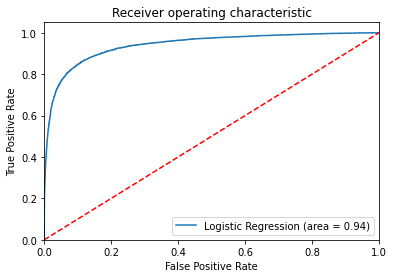

In [69]:
logit_roc_auc = roc_auc_score(y_resampled, result.predict(x_resampled))
fpr, tpr, thresholds = roc_curve(y_resampled, result.predict(x_resampled))
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

In [70]:
print(result.get_margeff().summary())

                Logit Marginal Effects               
Dep. Variable:     Would_live_in_another_neighborhood
Method:                                          dydx
At:                                           overall
                                                    dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Gender                                            -0.0273      0.004     -6.733      0.000      -0.035      -0.019
Owns_a_car                                        -0.0216      0.004     -4.923      0.000      -0.030      -0.013
BCN_over_barri_evolution                          -0.0242      0.009     -2.742      0.006      -0.042      -0.007
BCN_over_barri_future                             -0.0385      0.007     -5.894      0.000      -0.051      -0.026
BCN_over_barri_satisfaction_of_living             -0.0521      0.010     -5.241      0.000    

In [71]:
result.pred_table()

array([[11748.,  1545.],
       [ 1806., 11487.]])

In [ ]:
logit_roc_auc = roc_auc_score(y_resampled, result.predict(x_resampled))
fpr, tpr, thresholds = roc_curve(y_resampled, result.predict(x_resampled))
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

In [ ]:
np.exp(result.params)